<a href="https://colab.research.google.com/github/jonotassia/LearningEquality/blob/main/Learning_Equality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Equality

This notebook contains code to create a machine learning model to analyze educational content for K-12 educational materials using TensorFlow.

## Goal

The goal of this competition is to streamline the process of matching educational content to specific topics in a curriculum. You will develop an accurate and efficient model trained on a library of K-12 educational materials that have been organized into a variety of topic taxonomies. These materials are in diverse languages, and cover a wide range of topics, particularly in STEM (Science, Technology, Engineering, and Mathematics).

You are challenged to predict which content items are best aligned to a given topic in a topic tree, with the goal of matching the selections made by curricular experts and other users of the Kolibri Studio platform. In other words, your goal is to recommend content items to curators for potential inclusion in a topic, to reduce the time they spend searching for and discovering relevant content to consider including in each topic.

## Data

The training set consists of a corpus of topic trees from within the Kolibri Content Library, along with additional non-public aligned channels, and supplementary channels with less granular or lower-quality alignment.

* `topics.csv` - Contains a row for each topic in the dataset. These topics are organized into "channels", with each channel containing a single "topic tree" (which can be traversed through the "parent" reference). 
 * `id` - A unique identifier for this topic.
 * `title` - Title text for this topic.
 * `description` - Description text (may be empty)
 * `channel` - The channel (that is, topic tree) this topic is part of.
 * `category` - Describes the origin of the topic.
   * `source` - Structure was given by original content creator (e.g. the topic tree as imported from Khan Academy). There are no topics in the test set with this category.
   * `aligned` - Structure is from a national curriculum or other target taxonomy, with content aligned from multiple sources.
   * `supplemental` - This is a channel that has to some extent been aligned, but without the same level of granularity or fidelity as an aligned channel.
 * `language` - Language code for the topic. May not always match apparent language of its title or description, but will always match the language of any associated content items.
 * `parent` - The id of the topic that contains this topic, if any. This field if empty if the topic is the root node for its channel.
 * `level` - The depth of this topic within its topic tree. Level 0 means it is a root node (and hence its title is the title of the channel).
 * `has_content` - Whether there are content items correlated with this topic. Most content is correlated with leaf topics, but some non-leaf topics also have content correlations.

* `content.csv` - Contains a row for each content item in the dataset. Note that the hidden dataset used for scoring contains additional content items not in the public version. These additional content items are only correlated to topics in the test set. Some content items may not be correlated with any topic.
 * `id` - A unique identifier for this content item.
 * `title` - Title text for this content item.
 * `description` - Description text. May be empty.
language - Language code representing the language of this content item.
 * `kind` - Describes what format of content this item represents, as one of:
   * `document` (text is extracted from a PDF or EPUB file)
   * `video` (text is extracted from the subtitle file, if available)
   * `exercise` (text is extracted from questions/answers)
   * `audio` (no text)
   * `html5` (text is extracted from HTML source)
 * `text` - Extracted text content, if available and if licensing permitted (around half of content items have text content).
 * `copyright_holder` - If text was extracted from the content, indicates the owner of the copyright for that content. Blank for all test set items.
 * `license` - If text was extracted from the content, the license under which that content was made available. Blank for all test set items.

* `correlations.csv` - The content items associated to topics in the training set. A single content item may be associated to more than one topic. In each row, we give a topic_id and a list of all associated content_ids. These comprise the targets of the training set.



## Evaluation

Submissions will be evaluated based on their mean F2 score. The mean is calculated in a sample-wise fashion, meaning that an F2 score is calculated for every predicted row, then averaged.

## Toolkit

This project will leverage NumPy, Pandas, and MatplotLib for data analysis and visualisation. TensorFlow will be used to generate a machine learning model for this dataset.

In [1]:
# File handling libraries
from google.colab import files
import zipfile

# Data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Create directories and upload Kaggle JSON
files.upload()
! mkdir ~/.kaggle/
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (5).json
mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [3]:
# Kaggle API for datasets
import kaggle as kg

In [4]:
# Create and authenticate Kaggle client
kaggle = kg.KaggleApi()
kaggle.authenticate()

# Download dataset
kaggle.competition_download_files('learning-equality-curriculum-recommendations', path="./")

# Unzip dataset
with zipfile.ZipFile('./learning-equality-curriculum-recommendations.zip', 'r') as zipref:
  zipref.extractall('./')

# Delete zip file
! rm ./learning-equality-curriculum-recommendations.zip

## Data Exploration

Review data for information and trends ahead of building model. Features to investigate:
  * Available topics
  * Relative breakdown of content `kinds`

In [5]:
# Load content and topic dataframes
topic_df = pd.read_csv("./topics.csv")
content_df = pd.read_csv("./content.csv")
correlations_df = pd.read_csv("./correlations.csv")

In [6]:
topic_df.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


In [7]:
content_df.head()

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


In [8]:
correlations_df.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


In [9]:
# Find all topic titles
topic_df["title"].value_counts()

Assessments                                                       558
Videos                                                            341
Explore                                                           322
Lección 1                                                         306
Lección 2                                                         280
                                                                 ... 
Design Thinking                                                     1
Ionic equilibrium: Acids, bases, & salts                            1
Subtracting One-digit Numbers - Word Problems                       1
Графики на експоненциални функции                                   1
تحديد العلاقة بين الإحداثيّات القطبية والإحداثيّات الديكارتيّة      1
Name: title, Length: 45082, dtype: int64

In [10]:
len(pd.unique(topic_df["title"]))

45083

In [11]:
# Check if same title can be assigned to different parents
topic_df[topic_df["title"] == "Assessments"].head()

,id,title,description,channel,category,level,language,parent,has_content
100,t_006038bb5e62,Assessments,NaN,274269,supplemental,5,en,t_a6c4dc8775b0,True
146,t_008ae6ade193,Assessments,NaN,274269,supplemental,5,en,t_34ee4c2d62c6,True
234,t_00d443c50d2d,Assessments,NaN,760ea6,supplemental,4,en,t_2b2c076d875a,False
258,t_00e6e083fda9,Assessments,NaN,760ea6,supplemental,4,en,t_bfd6a702b751,True
303,t_0112beb69348,Assessments,NaN,274269,supplemental,5,en,t_d14f95a724cf,True


In [12]:
# Check if top-level parent topics can have content
topic_df[(topic_df["has_content"] == True) & (topic_df["parent"].isna())]

,id,title,description,channel,category,level,language,parent,has_content
4791,t_10035396d740,قناة كم كلمة لتمكين المعلّمين الناطقين باللغة ...,NaN,8dd5f3,source,0,ar,NaN,True
14579,t_30dd476279c8,Medicine,NaN,cc360a,supplemental,0,en,NaN,True
18764,t_3efcae0132f0,وزارة التربية والتعليم الأردنية,NaN,5139e9,source,0,ar,NaN,True
21106,t_470986f56fbe,Khan Academy - Standardized Test Preparation,NaN,653433,source,0,en,NaN,True
34384,t_72d1321023d9,Matemáticas Quinto Grado (Guatemala),NaN,f9db19,aligned,0,es,NaN,True
46122,t_9a710f5bd2da,Kolibri Library for Kenya,NaN,c7ca13,aligned,0,en,NaN,True
50600,t_a93e389f0f1a,Rajasthan State Hindi Channel,NaN,d2ac0e,supplemental,0,hi,NaN,True
57457,t_bff0c73af728,Malawi Mathematics Syllabus,NaN,a91e32,aligned,0,en,NaN,True
66200,t_dcb302962e2f,Laboratoria,NaN,fc9105,supplemental,0,es,NaN,True
67434,t_e0a4d54ef541,High School,NaN,50fe84,supplemental,0,en,NaN,True


Findings from topic analysis:
* There are 45083 unique topics titles in the dataset
* The same topic title can be the child of different parents
* It is very rare that content is assigned at the first node, but common enought to be relevant at intermediate nodes.


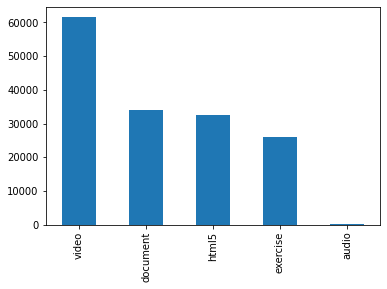

In [13]:
# Relative breakdown of content kinds
content_df["kind"].value_counts().plot(kind="bar");

Findings from content analysis:
* Largest kind of content is video, fewest is audio

## Data Cleansing and Prep

Before a model can be trained, the data needs to be cleansed. This will include the following steps:
* Remove rows without titles (very small number, low impact to dataset)
* Get label (topic) from `correlations.csv`
* Split content into train, validation, and test datasets
* Fill all NA values in each series of the dataframe
* Convert all category values to integers
* Normalize numeric values

### Remove NA Titles

In [14]:
topic_df.isna().sum()

id                 0
title              2
description    42019
channel            0
category           0
level              0
language           0
parent           171
has_content        0
dtype: int64

In [15]:
content_df.isna().sum()

id                      0
title                   9
description         64591
kind                    0
text                80012
language                0
copyright_holder    82226
license             80012
dtype: int64

In [16]:
# Remove rows without titles
topic_df.dropna(axis=0, subset=["title"], inplace=True)
topic_df.isna().sum()

id                 0
title              0
description    42018
channel            0
category           0
level              0
language           0
parent           171
has_content        0
dtype: int64

In [17]:
# Remove rows without titles
content_df.dropna(axis=0, subset=["title"], inplace=True)
content_df.isna().sum()

id                      0
title                   0
description         64585
kind                    0
text                80012
language                0
copyright_holder    82226
license             80012
dtype: int64

For remaining NaNs, validate datatype to determine suitability for category replacement or boolean.

In [18]:
# Fill remaining NaNs with "Missing" or "None" as relevant
topic_df["description"].fillna("missing", inplace=True)
topic_df["parent"].fillna("None", inplace=True)

content_df["description"].fillna("missing", inplace=True)
content_df["text"].fillna("missing", inplace=True)
content_df["copyright_holder"].fillna("none", inplace=True)
content_df["license"].fillna("none", inplace=True)

In [19]:
topic_df.isna().sum()

id             0
title          0
description    0
channel        0
category       0
level          0
language       0
parent         0
has_content    0
dtype: int64

In [20]:
content_df.isna().sum()

id                  0
title               0
description         0
kind                0
text                0
language            0
copyright_holder    0
license             0
dtype: int64

### Add labels (topics) to `content` DataFrame

* Define number of classes
* Convert topic names to number to prepare for one_hot encoding
* Convert `correlations` DataFrame to one row per content item
* Merge with `content` DataFrame


In [21]:
# Define number of classes as total number of topic names
NUM_CLASSES = correlations_df["topic_id"].nunique()
NUM_CLASSES

61517

In [22]:
# Convert correlations DataFrame to one row per content item
correlations_df["content_ids"] = correlations_df["content_ids"].apply(lambda x: x.split(" "))
correlations_df = correlations_df.explode(["content_ids"])
correlations_df.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d
0,t_00004da3a1b2,c_376c5a8eb028
0,t_00004da3a1b2,c_5bc0e1e2cba0
0,t_00004da3a1b2,c_76231f9d0b5e
1,t_00068291e9a4,c_639ea2ef9c95


In [23]:
# Merge content table with correlations table to access label (topic_id)
labeled_content_df = content_df.merge(correlations_df, left_on="id", right_on="content_ids")
labeled_content_df.drop(columns=["content_ids"], inplace=True)
labeled_content_df.rename(columns={"topic_id": "label"}, inplace=True)
labeled_content_df.head()

,id,title,description,kind,text,language,copyright_holder,license,label
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,missing,es,none,none,t_81be1094dd83
1,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,missing,es,none,none,t_d0edb1c53d90
2,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,missing,es,none,none,t_d66311c2e171
3,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,missing,es,none,none,t_e696cda1adb6
4,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,missing,es,none,none,t_f7f7dbd7d76a


### Create Train/Test/Valid splits

In [25]:
SAMPLE_FRAC_SIZE = 0.02

# Create test, validation, and training subset from content
train, test, valid = np.split(labeled_content_df.sample(frac=SAMPLE_FRAC_SIZE), [int(len(labeled_content_df)*SAMPLE_FRAC_SIZE*0.8), int(len(labeled_content_df)*SAMPLE_FRAC_SIZE*0.9)])
print(train.shape, test.shape, valid.shape)

(11194, 9) (1400, 9) (1400, 9)


In [26]:
# Create feature and label splits for each subset.
X_train = train.drop(columns=["label"])
y_train = pd.DataFrame(data=train["label"])

X_test = test.drop(columns=["label"])
y_test = pd.DataFrame(data=test["label"])

X_valid = valid.drop(columns=["label"])
y_valid = pd.DataFrame(data=valid["label"])

In [27]:
print(X_train.shape, X_test.shape, X_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

(11194, 8) (1400, 8) (1400, 8)
(11194, 1) (1400, 1) (1400, 1)


### Create Input Pipeline and Transform Data

In [28]:
# Create input pipeline with batch size of 32
def df_to_dataset(X, y, shuffle=True, batch_size=32, NUM_CLASSES=NUM_CLASSES):
  df = {key: value[:,tf.newaxis] for key, value in X.items()}
  # Convert to dataset
  ds = tf.data.Dataset.from_tensor_slices((df, tf.one_hot(y, NUM_CLASSES)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  # Batch dataset
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


In [29]:
# Create and batch datasets
batch_size = 32
train_ds = df_to_dataset(X_train, y_train, batch_size=batch_size)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)
valid_ds = df_to_dataset(X_valid, y_valid, shuffle=False, batch_size=batch_size)

<ipython-input-28-383d194f9abc>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in X.items()}


In [64]:
def convert_categories(column, dataset, dtype, max_tokens=None):
  """
  Convert categorical columns to one hot encoding.
  :param column: Feature to convert
  :param dataset: Dataset to pull features from
  :param dtype: Data type of column being passed in
  :param max_tokens: Max size of vocabulary
  """
  # Create layer that turns a string into integer indices
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)

  # Otherwise, convert integer values to integer indices
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Reduce dataset down to only the feature passed to function
  feature_ds = dataset.map(lambda x, y: x[column])

  # Learn the set of possible values (vocabulary) and assign to an index from above
  index.adapt(feature_ds)

  # Encode indices
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="multi_hot")

  # Use multi-hot encoding on the indices. Lambda func captures the layer.
  return lambda feature: encoder(index(feature))

In [65]:
# Define categorical columns for preprocessing
categorical_columns = ("id", "title", "kind", "language", "copyright_holder", "license")

# Define NLP columns
nlp_columns = ("text", "description")

In [66]:
# Test that layer will work in small-scale
[(train_features, label_batch)] = train_ds.take(1)
test_layer = convert_categories("kind", train_ds, "string")
test_layer(train_features["kind"])

<tf.Tensor: shape=(32, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.,

In [67]:
label_batch

<tf.Tensor: shape=(32, 1, 61517), dtype=float32, numpy=
array([[[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [68]:
# Create text vectorization layer for description
def vectorize_text(column, dataset, max_features=10000):
  """
  Vectorizes natural language.
  :param column: Feature to convert
  :param dataset: Dataset to pull features from
  :param max_features: Max size of vocabulary
  """
  # Create a text_vectorization layer
  vectorize_layer = tf.keras.layers.TextVectorization(
      max_tokens=max_features,
      output_mode="multi_hot"
  )

  # Create a feature dataset from main dataset for passed column
  feature_ds = dataset.map(lambda x, y: x[column])

  # Adapt feature dataset
  vectorize_layer.adapt(feature_ds)

  # Return encoder
  return lambda feature: vectorize_layer(feature)

In [69]:
# Test vectorization layer works with description
[(train_features, label_batch)] = train_ds.take(1)
vector_layer = vectorize_text("description", train_ds)
vector_layer(train_features["description"])

<tf.Tensor: shape=(32, 10000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [70]:
encoded_features = []
all_inputs = []

# Create a layer for each categorical column
for column in categorical_columns:
  col = tf.keras.Input(shape=(1,), name=column)
  all_inputs.append(col)
  layer = convert_categories(column, train_ds, "string")
  encoded_col = layer(col)
  encoded_features.append(encoded_col)

# Create a layer for each natural language column (description only)
for column in nlp_columns:
  col = tf.keras.Input(shape=(1,), name=column)
  all_inputs.append(col)
  layer = vectorize_text(column, train_ds)
  encoded_col = layer(col)
  encoded_features.append(encoded_col)



In [71]:
encoded_features

[<KerasTensor: shape=(None, 10616) dtype=float32 (created by layer 'category_encoding_16')>,
 <KerasTensor: shape=(None, 10281) dtype=float32 (created by layer 'category_encoding_17')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'category_encoding_18')>,
 <KerasTensor: shape=(None, 28) dtype=float32 (created by layer 'category_encoding_19')>,
 <KerasTensor: shape=(None, 65) dtype=float32 (created by layer 'category_encoding_20')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'category_encoding_21')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_vectorization_7')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_vectorization_8')>]

In [72]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'id')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'kind')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'language')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'copyright_holder')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'license')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'text')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'description')>]

In [73]:
INPUT_SHAPE = X_train.shape

### Build and Train Model

In [74]:
def create_compile_model(inputs, features, output_shape, optimizer="adam", metrics=["accuracy"]):
  """
  Creates and compiles a model based on features with parameters to modify activation layer and optimizer.
  "param inputs: Input columns for layers
  :param features: Encoding layers for each feature
  :param optimizer: Optimizer for the model
  :param metrics: Scoring metrics
  """  
  # Merge the list of input features
  all_features = tf.keras.layers.concatenate(features)

  # Create activation layer - defines activation threshold method
  x = tf.keras.layers.Dense(32, activation='relu')(all_features)

  # Create dropout layer - drops certain inputs to avoid overfitting
  x = tf.keras.layers.Dropout(0.2)(x)

  # Create output layer with size 1 so that only 1 category is ouput
  output = tf.keras.layers.Dense(units=output_shape, activation="softmax")(x)

  # Create model
  model = tf.keras.Model(inputs, output)

  # Compile model
  model.compile(optimizer=optimizer, 
                loss= "sparse_categorical_crossentropy",
                metrics=metrics)

  return model

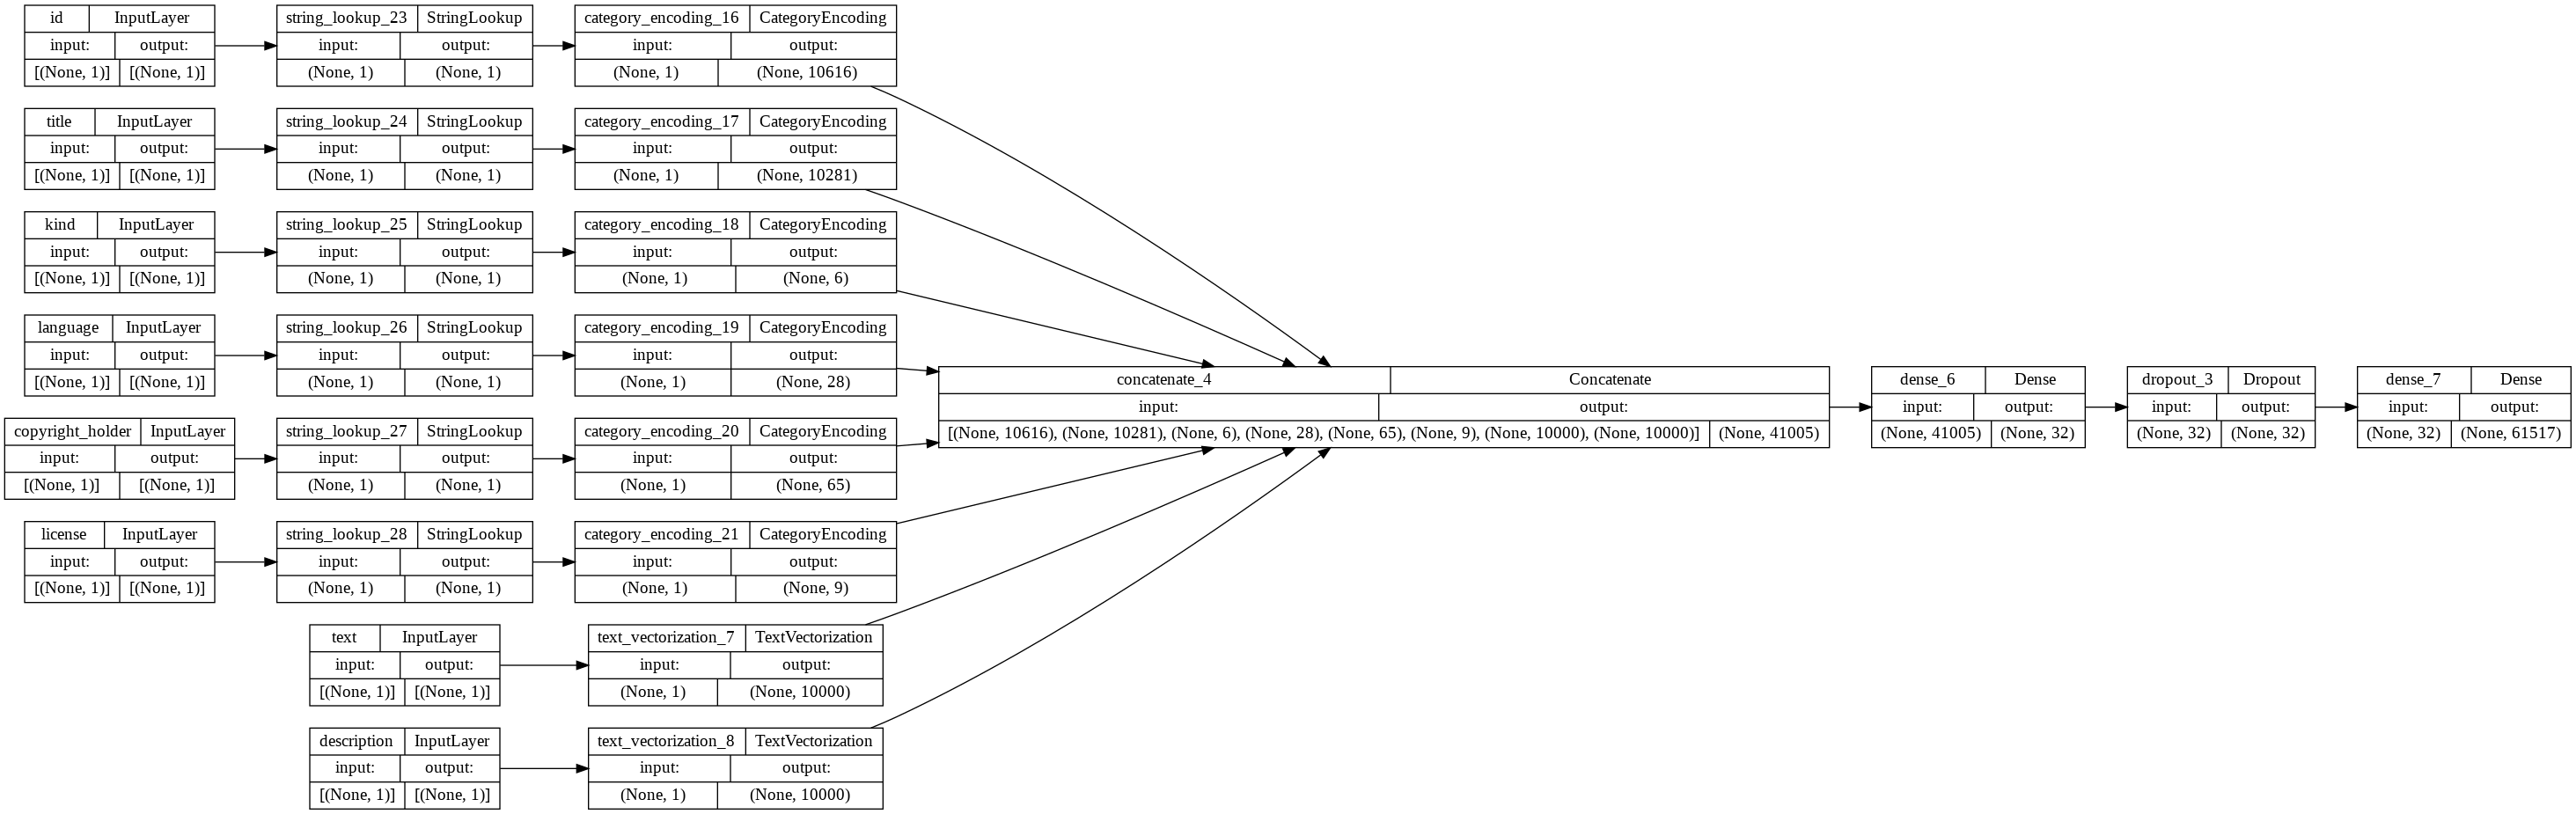

In [77]:
# Compile model
model = create_compile_model(all_inputs, encoded_features, NUM_CLASSES)

# Visualize model
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [78]:
# Fit model on train data
model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10


UnimplementedError: ignored